In [171]:
import matplotlib.pyplot as plt
import json
import numpy as np

In [172]:
models_default = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results", "BERT base cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results", "ELECTRA base discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results", "ELECTRA base generator"),
         ]
    )
]

models_wordsim = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results_word_similarity", "BERT-base cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results_word_similarity", "ELECTRA-base discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results_word_similarity", "ELECTRA-base generator"),
         ]
    )
]


models_mlm = [
    ("bert-base-cased", ["mean"], 13, 
         [
            ("test_results_bert-base-cased_model_epoch_9_mlm", "BERT-base cased"),
         ]
    ),
    ("google-electra-base-discriminator", ["mean"], 13, 
         [
            ("test_results_google-electra-base-discriminator_model_epoch_9_mlm", "ELECTRA-base discriminator"),
         ]
    ),
    ("google-electra-base-generator", ["mean"], 13, 
         [
            ("test_results_google-electra-base-generator_model_epoch_9_mlm", "ELECTRA-base generator"),
         ]
    )
]

models = [
    models_default, models_wordsim, models_mlm
]
colors=[
    [None, None, None]  for i in range(3)
]

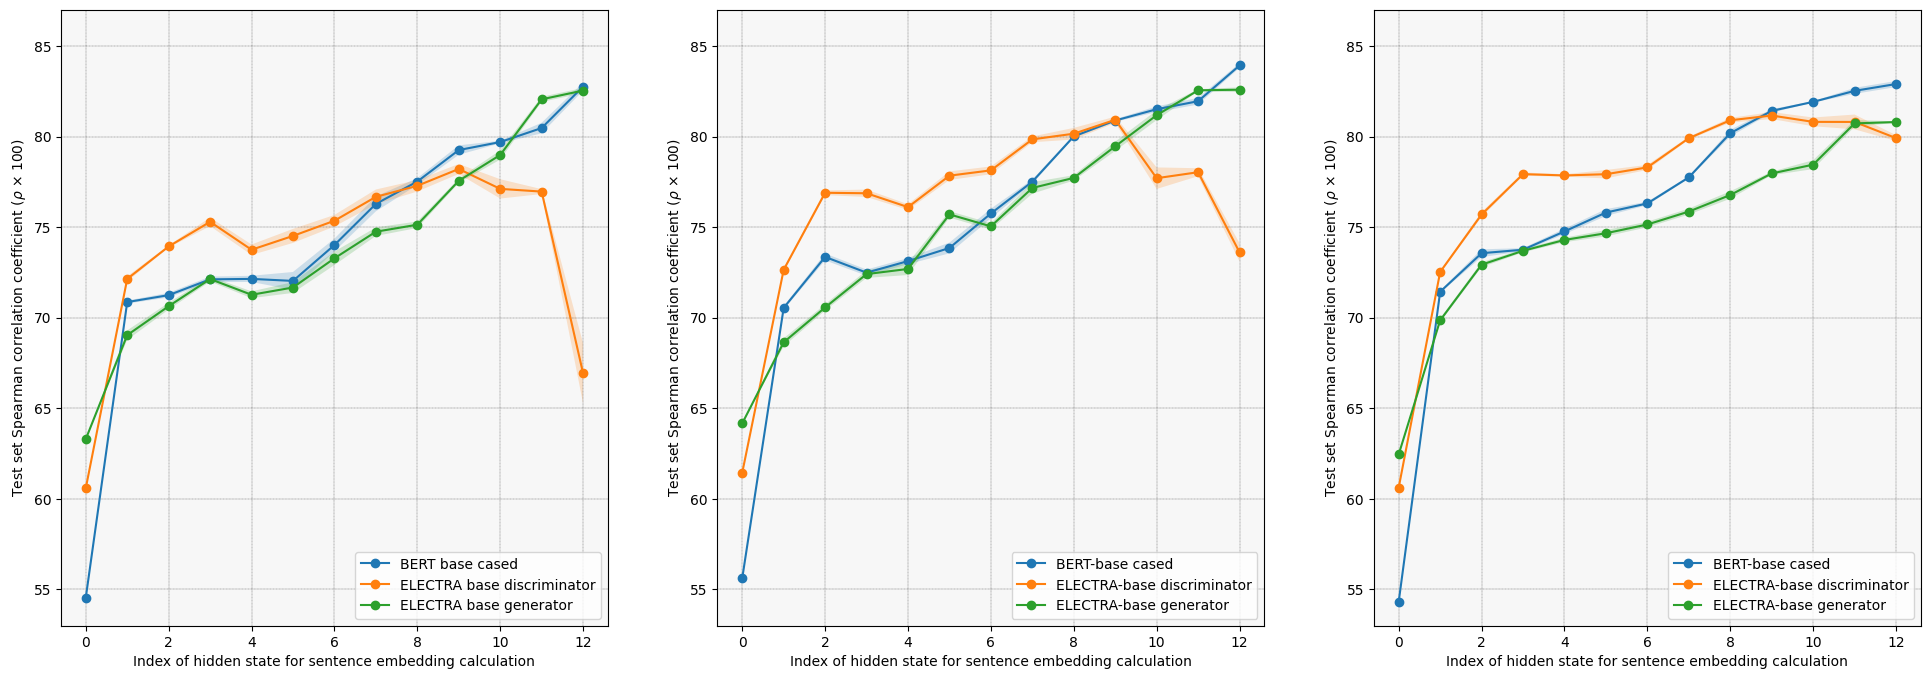

In [173]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

def add_to_plot(models, colors, ax, ylim_spearman=[53, 87]):
    for x, color in zip(models, colors):
        m = x[0]
        pool = x[1]
        c = x[2]
        json_names_labels = x[3]
        for p in pool:
            for (name, label) in json_names_labels:
                spearman, pearson = [], []
                std_spearman, std_pearson = [], []
                for i in range(c):
                    res = json.load(open(f"../output/{m}/{p}/{i}_to_{i+1}/{name}.json"))
                    
                    std_1 = np.array(res["stdev_cosine_spearman_test"]) * 100
                    mean_1 = res["mean_cosine_spearman_test"] * 100
                    std_spearman.append((mean_1-std_1, mean_1+std_1))
                    spearman.append(mean_1)

                    std_2 = np.array(res["stdev_cosine_pearson_test"]) * 100
                    mean_2 = res["mean_cosine_pearson_test"] * 100
                    std_pearson.append((mean_2-std_2, mean_2+std_2))
                    pearson.append(mean_2)

                ax.set_facecolor('#F7F7F7')
                ax.grid(color='black', linestyle='--', linewidth=0.2)
                ax.plot(spearman, "-o", label=label)
                ax.fill_between(
                    np.array(list(range(c))), 
                    np.array(std_spearman)[:,0], 
                    np.array(std_spearman)[:,1],
                    alpha=0.2
                )
                ax.set_xlabel("Index of hidden state for sentence embedding calculation")
                ax.set_ylabel("Test set Spearman correlation coefficient ($\\rho$ $\\times$ 100)")
                ax.legend(loc="lower right")
                if ylim_spearman is not None:
                    ax.set_ylim(ylim_spearman)


for m, c, ax in zip(models, colors, axs):
    add_to_plot(m, c, ax)

plt.savefig("./plots/comparison_plot.png", format="png", bbox_inches="tight")